# Predict fradulent money transactions

**objective**
- Preprocess the data ready for fitting ML models
- Apply different algorithms to generate better prediction on frauds

In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.set_palette('Set2')

SMALL_SIZE = 13
MEDIUM_SIZE = SMALL_SIZE + 6

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\n",
plt.rc('figure', dpi=150)

In [2]:
paysim = pd.read_csv("../data/paysim_for_ML.csv", index_col=0)
print(paysim.shape)
paysim.head()

/home/hyoj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6362620, 12)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB


# Feature engineering

To fit into a logistic regression model, we need all the features to be numeric

In [3]:
# Find transactions type which are possibly fraud: transfer or cashout
type_filter = (paysim['type'] == 'TRANSFER')|(paysim['type'] == 'CASH_OUT')

# Flag the rows only if their transaction types were either transfer or cashout
paysim['type_to_watch']=type_filter*1

In [4]:
# Let's map 'type' info into numeric values
paysim['type'] = paysim['type'].map({'PAYMENT':0, 'TRANSFER':1, 'CASH_OUT':2, 'DEBIT':3, 'CASH_IN':4})
paysim['type'].value_counts()

2    2237500
0    2151495
4    1399284
1     532909
3      41432
Name: type, dtype: int64

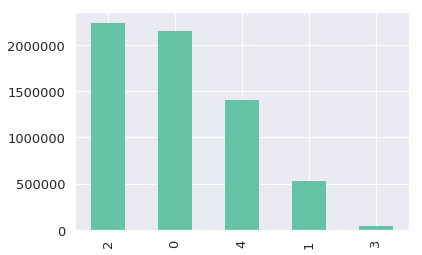

In [5]:
paysim['type'].value_counts().plot(kind='bar')

In [6]:
# Convert 'validTransactionType' into numeric values

paysim['validTransactionType'] = paysim['validTransactionType'].map({'CC':1, 'CB':2, 'BB':3, 'BC':4})
paysim['validTransactionType'].value_counts()

1    4211125
2    2151495
Name: validTransactionType, dtype: int64

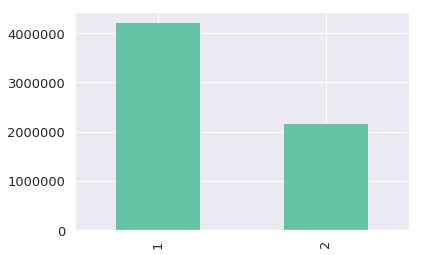

In [7]:
paysim['validTransactionType'].value_counts().plot(kind='bar')

In [8]:
# The target is highly unblanced:

paysim['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
features = [col for col in paysim.columns if col not in ['isFraud', 'nameOrig', 'nameDest']]
features

['step',
 'type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'validTransactionType',
 'type_to_watch']

# Prepare train and test sets to build predictive models

In [10]:
# Import libraries to split the data
from sklearn.model_selection import train_test_split

In [11]:
# Define features and the target
X = paysim[features]
y = paysim['isFraud']

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [12]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4453834 4453834
1908786 1908786


* Models to apply:
    1. Logistic regression
    2. Neural network
    3. Random forest
    4. XGBoost

# Modeling

## Build a baseline

In [13]:
# Use a logistic function (sigmoidal function) for a classic binary classification problem,
# in which the prediction input is a probability value between 0 and 1.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, roc_auc_score, roc_curve

## Data standardization

When implementing a logistic regression, standardizing the data to rescale all variables into a relatively similar range will result in similar distribution of standard deviation from the mean equals one.
<br>
<br>
Among various standardization techniques available in scikit-learn (e.g. MinMaxScaler, RobustScaler, Normalizer), we'll adopt StandardScaler so that all features can have same mean and unit variance.

In [14]:
# Import standardization method: StandardScaler
from sklearn.preprocessing import StandardScaler

In [15]:
# Initiate standard scaler
scaler = StandardScaler()

# Fit and transform the features from both train and test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4453834 4453834
1908786 1908786


In [17]:
logistic = LogisticRegression()
result = logistic.fit(X_train, y_train)

y_prediction_base = logistic.predict_proba(X_test)[:, 1]

/home/hyoj/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


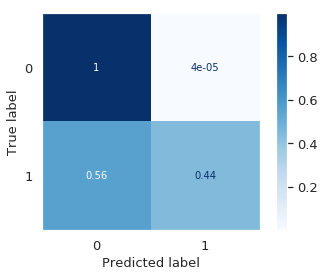

In [20]:
# Plot a confusion matrix using test sets
plot_confusion_matrix(logistic, X_test, y_test, cmap='Blues', normalize='true')
plt.grid(False)

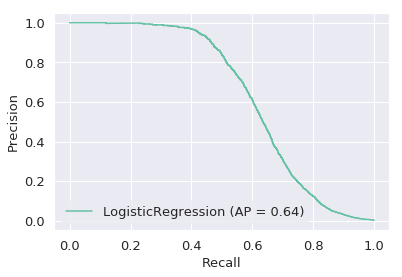

In [19]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)

base_precision_recall = plot_precision_recall_curve(logistic, X_test, y_test)
base_precision_recall

Area Under Curve: 0.983191270094523


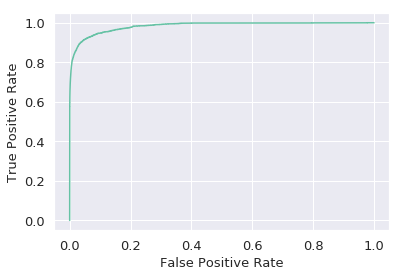

In [21]:
# Plot roc_curve
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_base)}')

fpr_base, tpr_base, _ = roc_curve(y_test, y_prediction_base)

plt.plot(fpr_base, tpr_base, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

*Note:
Low recall rate due to highly unbalanced target
Let's impose different weights on target and compensate the imbalance

In [22]:
# Proportion of target values
y.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

# Improve the model:

    1. Use different ML algorithms: logistic regression, neural network, random forest, XGBoost
    3. Penalize wrong predictions by imposing different weights on each class

## A. Logistic regression

### + Hyperparameter adjustment: Class weight

The ratio of not_fraud(0) vs. fraud(1) is almost 99.9 vs. 0.1 (%)
Therefore, by defining the class weights as inverse of label distribution, we can penalize the wrong prediction of the minorities much higher than that of the majorities.
To this end, we implement 'class_weight' hyperparameter of Logistic regression.

In [23]:
# Define class weights
weight = {0:0.1, 1:99.9}

In [24]:
# Try another logistic regression model to train with standardized model
logistic2 = LogisticRegression(class_weight=weight)
logistic2.fit(X_train, y_train)

y_prediction_logistic = logistic2.predict_proba(X_test)[:, 1]

/home/hyoj/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


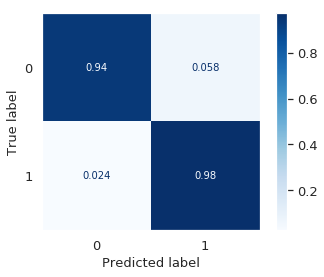

In [25]:
# Plot a confusion matrix using test sets
plot_confusion_matrix(logistic2, X_test, y_test, cmap='Blues', normalize='true')
plt.grid(False)

Area Under Curve: 0.9930158395216826


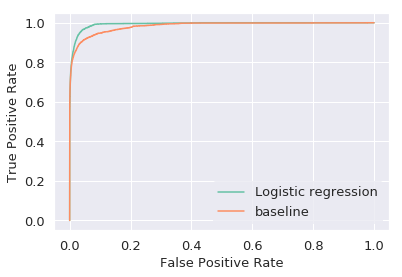

In [26]:
# Plot roc_curve
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_logistic)}')

fpr, tpr, _ = roc_curve(y_test, y_prediction_logistic)

plt.plot(fpr, tpr, label='Logistic regression')
plt.plot(fpr_base, tpr_base, label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

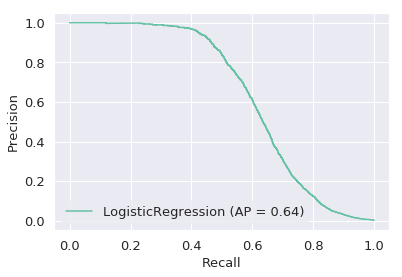

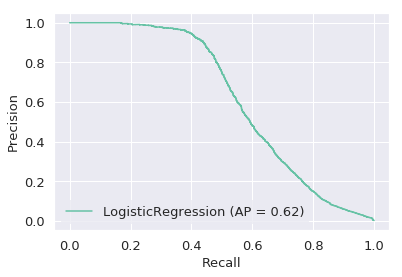

In [27]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)

base_precision_recall.plot()
plot_precision_recall_curve(logistic2, X_test, y_test)
plt.show()

Note:
- Recall score improved: Successfully reduced FNs but increased FPs
- Area under curve score higly increased
- Hyperparameter gridsearch can be added to improve the precision-recall scores


## B. Neural network

In [24]:
# Import libraries to build and evaluate the model
from tensorflow.keras import Sequential, layers, optimizers, metrics

In [25]:
# Layers
nn_layers = [
            layers.Dense(16, activation='relu', input_shape=(10,)), # 10 features
            layers.Dense(8, activation='relu'),
            layers.Dense(1, activation='sigmoid') # 1 output
            ]

# Creating a sequential model
nn_model = Sequential(nn_layers)

In [26]:
# # Recompile and train
# nn_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metrics.AUC()])

# # Class weight
# nn_model.fit(X_train, y_train, epochs=3, class_weight=weight, validation_data=(X_test, y_test))

In [27]:
# Recompile and train
nn_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metrics.AUC()])

# Class weight not applied
nn_model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
139183/139183 [==============================] - 228s 2ms/step - loss: 0.0040 - auc: 0.9123 - val_loss: 0.0027 - val_auc: 0.9323
Epoch 2/3
139183/139183 [==============================] - 229s 2ms/step - loss: 0.0029 - auc: 0.9343 - val_loss: 0.0026 - val_auc: 0.9391
Epoch 3/3
139183/139183 [==============================] - 222s 2ms/step - loss: 0.0028 - auc: 0.9408 - val_loss: 0.0023 - val_auc: 0.9559


In [28]:
# Generate predicted y values
y_prediction_nn = nn_model.predict_proba(X_test)

Instructions for updating:
Please use `model.predict()` instead.


Area Under Curve: 0.9946616533640773


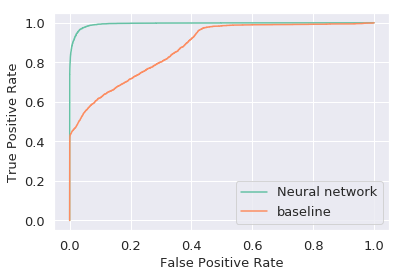

In [29]:
# Print the auc score
print(f'Area Under Curve: {roc_auc_score(y_test, y_prediction_nn)}')

# Plot roc_curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prediction_nn)

plt.plot(fpr_nn, tpr_nn, label='Neural network')
plt.plot(fpr_base, tpr_base, label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)

base_precision_recall.plot()
plot_precision_recall_curve(logistic2, X_test, y_test)
plot_precision_recall_curve(nn_model, X_test, y_test)